In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


**<mark><font color = black size=5>Dataset</font><mark>**

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, full_list=None,transform=None, pixel_dir=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.pixel_dir = pixel_dir
        self.transform  = transform
        self.is_train   = is_train
        
        if self.is_train == 1:
            self.images = full_list              
        elif self.is_train == 2:
            self.images = os.listdir(self.input_dir)
        else:
            self.images = os.listdir(self.input_dir)            

            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        mask        = np.ones(mask.shape)-mask

        if self.pixel_dir:
            mask_pixel_path=os.path.join(self.pixel_dir, self.images[index])
            mask_pixel= np.array(Image.open(mask_pixel_path).convert("L"), dtype=np.float32)   / 255
            
            if self.transform is not None:
                augmentations = self.transform(image=img, mask=mask_pixel) 
                aug2 = self.transform(image=img, mask=mask)
                img   = augmentations["image"]
                mask_pixel = augmentations["mask"]  
                mask  = aug2["mask"]
                
            mask=np.round(mask)
            mask_pixel=np.round(mask_pixel)
            return img, mask, mask_pixel
        
        elif self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]

        mask=np.round(mask)
        return img, mask, mask_path

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, full_list=None,transform=None, pixel_dir=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.pixel_dir = pixel_dir
        self.transform  = transform
        self.is_train   = is_train
        
        if self.is_train == 1:
            self.images = full_list              
        elif self.is_train == 2:
            self.images = os.listdir(self.input_dir)
        else:
            self.images = os.listdir(self.input_dir)             
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        mask        = np.ones(mask.shape)-mask

        if self.pixel_dir:
            mask_pixel_path=os.path.join(self.pixel_dir, self.images[index])
            mask_pixel= np.array(Image.open(mask_pixel_path).convert("L"), dtype=np.float32)   / 255
            
            if self.transform is not None:
                augmentations = self.transform(image=img, mask=mask_pixel) 
                aug2 = self.transform(image=img, mask=mask)
                img   = augmentations["image"]
                mask_pixel = augmentations["mask"]  
                mask  = aug2["mask"]
                
            mask=np.round(mask)
            mask_pixel=np.round(mask_pixel)
            return img, mask, mask_pixel
        
        elif self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]

        mask=np.round(mask)

        return img, mask, mask_path

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, full_list=None,transform=None, pixel_dir=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.pixel_dir = pixel_dir
        self.transform  = transform
        self.is_train   = is_train
        
        if self.is_train == 1:
            self.images = full_list              
        elif self.is_train == 2:
            self.images = os.listdir(self.input_dir)
        else:
            self.images = os.listdir(self.input_dir)             
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        mask        = np.ones(mask.shape)-mask

        if self.pixel_dir:
            mask_pixel_path=os.path.join(self.pixel_dir, self.images[index])
            mask_pixel= np.array(Image.open(mask_pixel_path).convert("L"), dtype=np.float32)   / 255
            
            if self.transform is not None:
                augmentations = self.transform(image=img, mask=mask_pixel) 
                aug2 = self.transform(image=img, mask=mask)
                img   = augmentations["image"]
                mask_pixel = augmentations["mask"]  
                mask  = aug2["mask"]
                
            mask=np.round(mask)
            mask_pixel=np.round(mask_pixel)
            return img, mask, mask_pixel
        
        elif self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]

        mask=np.round(mask)
        return img, mask, mask_path

**<mark><font color = black size=5>Hyperparameters and Initializations</font><mark>**

In [5]:
TRAIN_INP_DIR = '/root/Desktop/Brickwall_448/train/images'
TRAIN_OUT_DIR = '/root/Desktop/Brickwall_448/train/masks'
VAL_INP_DIR = '/root/Desktop/Brickwall_448/test/images'
VAL_OUT_DIR = '/root/Desktop/Brickwall_448/test/masks'

DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 0.00005 
BATCH_SIZE    = 2
NUM_EPOCHS    = 80
IMAGE_HEIGHT  = 448  
IMAGE_WIDTH   = 448 

train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=IMAGE_HEIGHT, min_width=IMAGE_WIDTH, always_apply=True, border_mode=0),
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=IMAGE_HEIGHT, min_width=IMAGE_WIDTH, always_apply=True, border_mode=0),
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        ToTensorV2(),
    ],
)



**<mark><font color = black size=5> Get_loaders to return train_loader and val_loader </font><mark>**

In [7]:
def get_loaders( inp_dir, mask_dir, test_inp, test_out, batch_size,  train_transform, val_tranform ):
    full_list= os.listdir(inp_dir)  
    random.shuffle(full_list)
    
    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir, 
                    is_train= 1, full_list=full_list,transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=test_inp, output_dir=test_out,
                     is_train= 2, full_list=full_list,transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

**<mark><font color = black size=5> Check Data loader </font><mark>**

torch.Size([1, 3, 448, 448])
torch.Size([1, 448, 448])
min=:0.0
max=:1.0



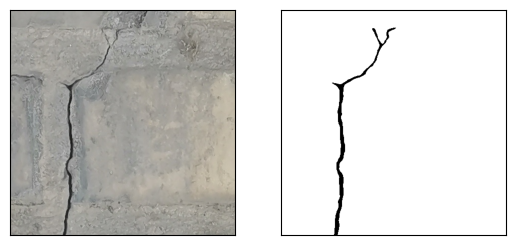

In [8]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR, VAL_INP_DIR, VAL_OUT_DIR,
                            BATCH_SIZE,  train_transform, val_transform)
inputs, masks,img_path = next(iter(val_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0),cmap=plt.cm.binary)
ax[1].imshow(masks[0].squeeze(0),cmap=plt.cm.binary)

for i in range(2):
    ax[i].axes.get_xaxis().set_visible(False)
    ax[i].axes.get_yaxis().set_visible(False)
# _,ax  = plt.subplots(1,1)
# ax.imshow(inputs[0].permute(1,2,0))
# ax[1].imshow(masks[0])
# _,ax  = plt.subplots(1,1)
# ax.imshow(masks[0])

print(inputs[0].unsqueeze(0).size())
print(masks[0].unsqueeze(0).size())
min=torch.min(masks[0])
max=torch.max(masks[0])
print("min=:{}\nmax=:{}\n".format(min,max))

**<mark><font color = black size=5> Models_Selection </font><mark>**

#### VM_UNet

In [ ]:
from VMUNet.models.vmunet import VMUNet
model_config = {
        'num_classes': 1, 
        'input_channels': 3, 
        # ----- VM-UNet ----- #
        'depths': [2,2,2,2],
        'depths_decoder': [2,2,2,1],
        'drop_path_rate': 0.2,
        'load_ckpt_path': './pre_trained_weights/vmamba_small_e238_ema.pth',
    }

model= VMUNet(num_classes=1, input_channels=3, depths=[2,2,2,2], depths_decoder=[2,2,2,1], drop_path_rate=0.2,
             ).cuda()
# model= VMUNet(num_classes=1, input_channels=3, depths=[2,2,2,2], depths_decoder=[2,2,2,1], drop_path_rate=0.2,
#              load_ckpt_path='./pre_trained_weights/vmamba_small_e238_ema.pth').cuda()
model.load_from()
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

#### Segformer-B5

In [ ]:
from Segformer import *
import torch
from torchvision import io
from torchvision import transforms as T
model=eval('SegFormer')(backbone='MiT-B5',num_classes=1)   # eval change "strings" to "dict"
# model.backbone.load_state_dict(torch.load('./mit_pretrained/mit_b0.pth'),strict=False)   # ignore dis-matching keys
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

#### DTrC_Net

In [ ]:
from DTrC_Net.CTCNet import CTCNet
model=CTCNet().cuda()
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

#### Swin_UNet

In [ ]:
from SwinUNet.vision_transformer import SwinUnet
model = SwinUnet(img_size=448, num_classes=1, 
                 load_ckpt_path='./SwinUNet/swin_tiny_patch4_window7_224.pth').cuda()
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

#### Trans_UNet

In [ ]:
import numpy as np
from TransUnet.vit_seg_modeling import VisionTransformer as TransUNet
from TransUnet.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

config_transunet = CONFIGS_ViT_seg['R50-ViT-B_16']
input_size=1024
config_transunet.n_classes = 1
config_transunet.n_skip = 3
config_transunet.patches.grid = (int(input_size / 16), int(input_size / 16))
model = TransUNet(config_transunet, input_size, num_classes=1).cuda()
# model.load_from(weights=np.load(config_transunet.pretrained_path))
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

#### LinkNet-EB7

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Linknet(encoder_name='efficientnet-b7',encoder_weights='imagenet', in_channels=3, classes=1, activation= None).cuda()
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

#### UNet_EB7

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet(encoder_name='efficientnet-b7',encoder_weights='imagenet', in_channels=3, classes=1, activation= None).cuda()
total_params = sum(param.numel() for param in model.parameters())
print(total_params)

**<mark><font color = black size=3> unload weights Dice 0.138 & load weights Dice 0.355 </font><mark>**

In [10]:
#########  decoder_head_forward ########
def forward(image):    
    out= model(image)
    return out

In [15]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    iou_score   = 0
    Precision   = 0
    Recall      = 0
    model.eval()          

    with torch.no_grad():
        for img, mask,img_path in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(forward(img))
            preds = (preds > 0.5).float()
            N=preds.size()[0]
            preds= preds.view(N,-1)
            mask= mask.view(N,-1)
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            TP = preds * mask        
            Precision += (TP.sum(1)/(preds.sum(1)+ 1e-7)).sum()/N
            Recall    += (TP.sum(1)/(mask.sum(1)+ 1e-7)).sum()/N
############################ Output Metrics ##############################

            intersection= TP
            dice_score += ((2 * intersection.sum(1)) / ((preds + mask).sum(1) + 1e-7 )).sum()/N
            iou_score += ((intersection.sum(1))/((preds + mask).sum(1)- intersection.sum(1) + 1e-7)).sum()/N
    
    print((preds).sum(), Precision)
    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels:.3f}"
    )
    ave_prec=Precision/len(loader)
    ave_recall= Recall/len(loader)
    print(f"Precision: {ave_prec:.3f}", f"Recall: {ave_recall:.3f}")
    ave_dice_score= dice_score/len(loader)
    ave_iou_score= iou_score/len(loader)
    print(f"Dice score: {ave_dice_score:.3f}")  
    print(f"Iou score: {ave_iou_score:.3f}")
    model.train()
    return ave_dice_score

**<mark><font color = black size=5> Defined loss function </font><mark>**

In [16]:
class Selfdefined_Loss():
    def __init__(self):     
        pass

    def JaccardLoss(self, pr, gt):
        pr = torch.sigmoid(pr)  
        eps=1e-7
        N=gt.size()[0]
        pr_flat= pr.view(N,-1)
        gt_flat= gt.view(N,-1)
        intersection=pr_flat*gt_flat
        iou_score =(intersection.sum(1) + eps)\
              / (gt_flat.sum(1) + pr_flat.sum(1) - intersection.sum(1) + eps)
        loss=1-iou_score.sum() / N
        return loss 

    def DiceLoss(self, pr, gt):
        pr = torch.sigmoid(pr)  
        eps=1e-7
        beta=1
        N=gt.size()[0]
        pr_flat= pr.view(N,-1)
        gt_flat= gt.view(N,-1)
        tp = pr_flat * gt_flat        
        fp = pr_flat - tp
        fn = gt_flat - tp
        f_score = ((1 + beta ** 2) * tp.sum(1) + eps) \
            / ((1 + beta ** 2) * tp.sum(1) + beta ** 2 * fn.sum(1) + fp.sum(1) + eps)
        loss=1-f_score.sum()/N  
        return loss  
    

**<mark><font color = black size=5> Model, loss function, and optimizer </font><mark>**

In [17]:
loss_fn   = Selfdefined_Loss().DiceLoss 

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)


**<mark><font color = black size=5> Training Function and val loss </font><mark>**

In [18]:
def train_fn(loader, model, optimizer, loss_fn):

    loop = tqdm(loader)
    epoch_loss= []
    for batch_idx, (image, mask, img_path) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = forward(image)
        loss = loss_fn(predictions, mask)
    
        # backward
        model.zero_grad()
        loss.backward()
        epoch_loss.append(loss.item())
        optimizer.step()                 
        
        loop.set_postfix(loss=loss.item())
    loss_train.append(sum(epoch_loss)/len(epoch_loss))

def val_loss(loader, model,loss_fn):
    model.eval()
    loop = tqdm(loader)
    epoch_loss= []
    for batch_idx, (image, mask, img_path) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)
        predictions = forward(image)
        loss = loss_fn(predictions, mask)
        epoch_loss.append(loss.item())
    loss_val.append(sum(epoch_loss)/len(epoch_loss))

**<mark><font color = black size=5> Check accuracy before any training </font><mark>**

In [19]:
check_accuracy(val_loader, model, device=DEVICE)


100%|█████████████████████████████████████████| 176/176 [00:09<00:00, 18.96it/s]

tensor(61939., device='cuda:0') tensor(6.3423, device='cuda:0', dtype=torch.float64)
Got 48379479/70447104 with pixel accuracy 0.687
Precision: 0.036 Recall: 0.281
Dice score: 0.059
Iou score: 0.031


tensor(0.0594, device='cuda:0', dtype=torch.float64)

**<mark><font color = black size=5> Train the model and check the accuracy after each epoch </font><mark>**

In [ ]:
max_score = 0
loss_train=  []
loss_val = []
for epoch in range(NUM_EPOCHS):
    
    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    val_loss(val_loader, model,loss_fn)

    # check validation accuracy------- or prediction
    ave_dice_score = check_accuracy(val_loader, model, device=DEVICE)
    if max_score < ave_dice_score:
        max_score = ave_dice_score
        torch.save(model, './VMamba_UNet_448x448_pretrained_weights.pth')
        print('Model saved!')
         

plt.plot(loss_train, 'r', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# plt.savefig('000.png')

In [ ]:
Got 69356299/70447104 with pixel accuracy 0.985
Precision: 0.758 Recall: 0.783
Dice score: 0.757
Iou score: 0.651
Model saved!
########################## epoch: 39